In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from math import ceil
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl
import re


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
os.getcwd()

'D:\\kaggle\\predict_future_sales\\competitive-data-science-predict-future-sales'

# Data Description
* You are provided with daily historical sales data.
* The task is to forecast the total amount of products sold in every shop for the test set.
* Note that the list of shops and products slightly changes every month.
* Creating a robust model that can handle such situations is part of the challenge.

# File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

# Load Data & Columns description
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [2]:
%%time
train=pd.read_csv("sales_train.csv",encoding='utf-8')
test=pd.read_csv("test.csv",encoding='utf-8')
items=pd.read_csv("items.csv",encoding='utf-8')
item_cats=pd.read_csv("item_categories.csv",encoding='utf-8')
shops=pd.read_csv("shops.csv",encoding='utf-8')

#date 열 datetime 으로 변경
train['date']=pd.to_datetime(train.date, format='%d.%m.%Y')

Wall time: 1.84 s


In [3]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0


In [4]:
test.head(1)

,ID,shop_id,item_id
0,0,5,5037


In [5]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [6]:
item_cats.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [7]:
shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


# Name correction function
* codes referenced: https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
* .partition('str') : split strings by reference of 'str'
* re.sub('exp','non exp changing reference', data)
* .replace('a', 'b') : replace a with b 
* .strip() : strip blanks 

In [8]:
## name corretion func 
# 1) lower caplitalize string 
# 2) split by '[' and '('
# 3) drop special strings( select eng/num/russian only )
# 4) replace double space to space
# 5) drop balnks 

def name_correction(x):
    x = x.lower() # lower capitalize string
    x = x.partition('[')[0] 
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) #just select eng/num/russian
    x = x.replace('  ', ' ') #replace '  ' to ' '
    x = x.strip() # delete blanks
    return x

In [60]:
'во власти наваждения (пласт.) d '.partition('(')[0]

'во власти наваждения '

# drop duplicated rows

In [9]:
subset=['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset,inplace=True)

False    2935825
True          24
dtype: int64


In [10]:
print(train.duplicated(subset=subset).value_counts())

False    2935825
dtype: int64


# 1. items 
### item_name : drop special str only 

In [11]:
items['item_name'] = items['item_name'].apply(name_correction)
items.loc[:2,['item_id','item_name']]

,item_id,item_name
0,0,во власти наваждения
1,1,abbyy finereader 12 professional edition full
2,2,в лучах славы


In [ ]:
item

# 2. item_cats
### item_category_name : split main / sub category

In [12]:
item_cats['item_category_main'] = item_cats['item_category_name'].str.split(' - ')\
                                .apply(lambda x : x[0])
item_cats['item_category_sub'] = item_cats['item_category_name'].str.split(' - ')\
                                .apply(lambda x : x[-1])
item_cats.loc[:2,['item_category_name','item_category_main','item_category_sub']]

,item_category_name,item_category_main,item_category_sub
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,Аксессуары,PS2
2,Аксессуары - PS3,Аксессуары,PS3


# 3. shops : split shop_city / shop_type 
#### 몇가지 문제점 발생
#### 1) name_correction 진행 시, H.Новгород에 대한 파싱이 잘못됨 
* н.новгород(city) / трц(type) / фантастика(etc) [정상]
* н(city) /новгород(type) / трц фантастика(etc) [비정상]
#### ->  H.Новгород -> Нижний_Новгород 이므로 H만 따로 빠져나온거 풀네임 다시 돌려놓고 진행

In [13]:
shops['shop_city'] = shops['shop_name'].apply(name_correction).str.split(' ')\
                    .apply(lambda x: x[0])
shops['shop_city'].value_counts()

москва          13
якутск           4
тюмень           3
ростовнадону     3
воронеж          3
казань           2
спб              2
самара           2
уфа              2
новосибирск      2
н                2
жуковский        2
красноярск       2
вологда          1
ярославль        1
волжский         1
адыгея           1
мытищи           1
омск             1
химки            1
сургут           1
коломна          1
томск            1
цифровой         1
интернет         1
калуга           1
балашиха         1
курск            1
чехов            1
сергиев          1
выездная         1
Name: shop_city, dtype: int64

In [14]:
shops.loc[shops.shop_city=='н',['shop_name','shop_city']].head(3)

,shop_name,shop_city
34,"Н.Новгород ТРЦ ""РИО""",н
35,"Н.Новгород ТРЦ ""Фантастика""",н


In [15]:
shops.loc[shops.shop_city=='н',['shop_city']] = 'нижний_новгород'

In [16]:
shops.loc[shops.shop_city=='н']

,shop_name,shop_id,shop_city


#### 2) shop_name 이 city+type+etc로 구성되지 않고 city+etc이거나 다른 경우 존재, 이 경우 type가 없으므로 'others'로 퉁 치기

In [17]:
shops['shop_type'] = shops['shop_name'].apply(name_correction).str.split(' ').apply(lambda x: x[1] if (len(x)>1) else 'other')
shops['shop_type'].value_counts()

тц              27
трц              9
трк              5
тк               5
орджоникидзе     2
ул               2
магазин          2
новгород         2
распродажа       1
склад            1
other            1
посад            1
торговля         1
мтрц             1
Name: shop_type, dtype: int64

In [18]:
shop_type_other = ((shops['shop_type']=='орджоникидзе')|
                  (shops['shop_type']=='ул')|
                  (shops['shop_type']=='распродажа')|
                  (shops['shop_type']=='торговля')|
                  (shops['shop_type']=='магазин'))
shops.loc[shop_type_other]

,shop_name,shop_id,shop_city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,якутск,орджоникидзе
9,Выездная Торговля,9,выездная,торговля
10,Жуковский ул. Чкалова 39м?,10,жуковский,ул
11,Жуковский ул. Чкалова 39м²,11,жуковский,ул
12,Интернет-магазин ЧС,12,интернет,магазин
20,"Москва ""Распродажа""",20,москва,распродажа
22,Москва Магазин С21,22,москва,магазин
57,"Якутск Орджоникидзе, 56",57,якутск,орджоникидзе


In [19]:
shops.loc[shop_type_other,'shop_type'] = 'other'

In [20]:
shops.loc[(shops['shop_type']=='новгород')|
           (shops['shop_type']=='мтрц'),['shop_name','shop_city','shop_type']]

,shop_name,shop_city,shop_type
21,"Москва МТРЦ ""Афи Молл""",москва,мтрц
34,"Н.Новгород ТРЦ ""РИО""",нижний_новгород,новгород
35,"Н.Новгород ТРЦ ""Фантастика""",нижний_новгород,новгород


In [21]:
shops.loc[(shops['shop_type']=='новгород')|
           (shops['shop_type']=='мтрц'),'shop_type'] = 'трц' 

In [22]:
shops.loc[(shops['shop_type']=='новгород')|
           (shops['shop_type']=='мтрц'),:]

,shop_name,shop_id,shop_city,shop_type


In [23]:
shops.loc[(shops['shop_type']=='посад'), :]

,shop_name,shop_id,shop_city,shop_type
46,"Сергиев Посад ТЦ ""7Я""",46,сергиев,посад


In [24]:
shops.loc[(shops['shop_type']=='посад'), 'shop_type'] = 'тц'
shops.loc[shops['shop_name']=='Сергиев Посад ТЦ "7Я"']

,shop_name,shop_id,shop_city,shop_type
46,"Сергиев Посад ТЦ ""7Я""",46,сергиев,тц


In [25]:
shops['shop_type'].value_counts()

тц       28
трц      12
other     9
трк       5
тк        5
склад     1
Name: shop_type, dtype: int64

# Merge Data
* train 파일 기반으로 흩어져 있는 데이터 병합
* revenue 열 생성 : item_price * item_cnt_day 

In [26]:
#merge data
train=pd.merge(train,items,how='left',on='item_id')
train=pd.merge(train,item_cats,how='left',on='item_category_id')
train=pd.merge(train,shops,how='left',on='shop_id')

#make columns 'revenue'
train['revenue'] = train['item_price'] * train['item_cnt_day']
train.head(1)

train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,item_category_main,item_category_sub,shop_name,shop_city,shop_type,revenue
0,2013-01-02,0,59,22154,999.0,1.0,явление 2012,37,Кино - Blu-Ray,Кино,Blu-Ray,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.0


### columns index arrange

In [27]:
train=train.reindex(columns=[
        'date', 'date_block_num',  
        'item_id', 'item_name', 'item_price','item_cnt_day',          
        'item_category_id','item_category_name','item_category_main', 'item_category_sub', 
        'shop_id','shop_name','shop_city', 'shop_type',
        'revenue'])
train.head(1)

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue
0,2013-01-02,0,22154,явление 2012,999.0,1.0,37,Кино - Blu-Ray,Кино,Blu-Ray,59,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.0


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935825 entries, 0 to 2935824
Data columns (total 15 columns):
date                  datetime64[ns]
date_block_num        int64
item_id               int64
item_name             object
item_price            float64
item_cnt_day          float64
item_category_id      int64
item_category_name    object
item_category_main    object
item_category_sub     object
shop_id               int64
shop_name             object
shop_city             object
shop_type             object
revenue               float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(7)
memory usage: 358.4+ MB


In [29]:
train.isna().sum()

date                  0
date_block_num        0
item_id               0
item_name             0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
item_category_main    0
item_category_sub     0
shop_id               0
shop_name             0
shop_city             0
shop_type             0
revenue               0
dtype: int64

# EDA(by Columns)

## 1. [ Date ] 
* 연 기준: 거래횟수 감소추세 (2013 > 2014 > 2015)
* 월 기준: 12,1,2,3 월 거래횟수 많음
* 일 기준: 거래횟수 비슷비슷

In [30]:
print('[ date ]')
print('- Unique : {}'.format(train.date.nunique()))
print('- Min : {}'.format(train.date.min()))
print('- Max : {}'.format(train.date.max()))

[ date ]
- Unique : 1034
- Min : 2013-01-01 00:00:00
- Max : 2015-10-31 00:00:00


In [31]:
train['year_month']=train['date'].apply(lambda x: x.strftime('%Y-%m'))
train['year']=train.date.dt.year
train['month']=train.date.dt.month
train['day']=train.date.dt.day
train.head(3)

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
0,2013-01-02,0,22154,явление 2012,999.0,1.0,37,Кино - Blu-Ray,Кино,Blu-Ray,59,"Ярославль ТЦ ""Альтаир""",ярославль,тц,999.0,2013-01,2013,1,2
1,2013-01-03,0,2552,deep purple the house of blue light lp,899.0,1.0,58,Музыка - Винил,Музыка,Винил,25,"Москва ТРК ""Атриум""",москва,трк,899.0,2013-01,2013,1,3
2,2013-01-05,0,2552,deep purple the house of blue light lp,899.0,-1.0,58,Музыка - Винил,Музыка,Винил,25,"Москва ТРК ""Атриум""",москва,трк,-899.0,2013-01,2013,1,5


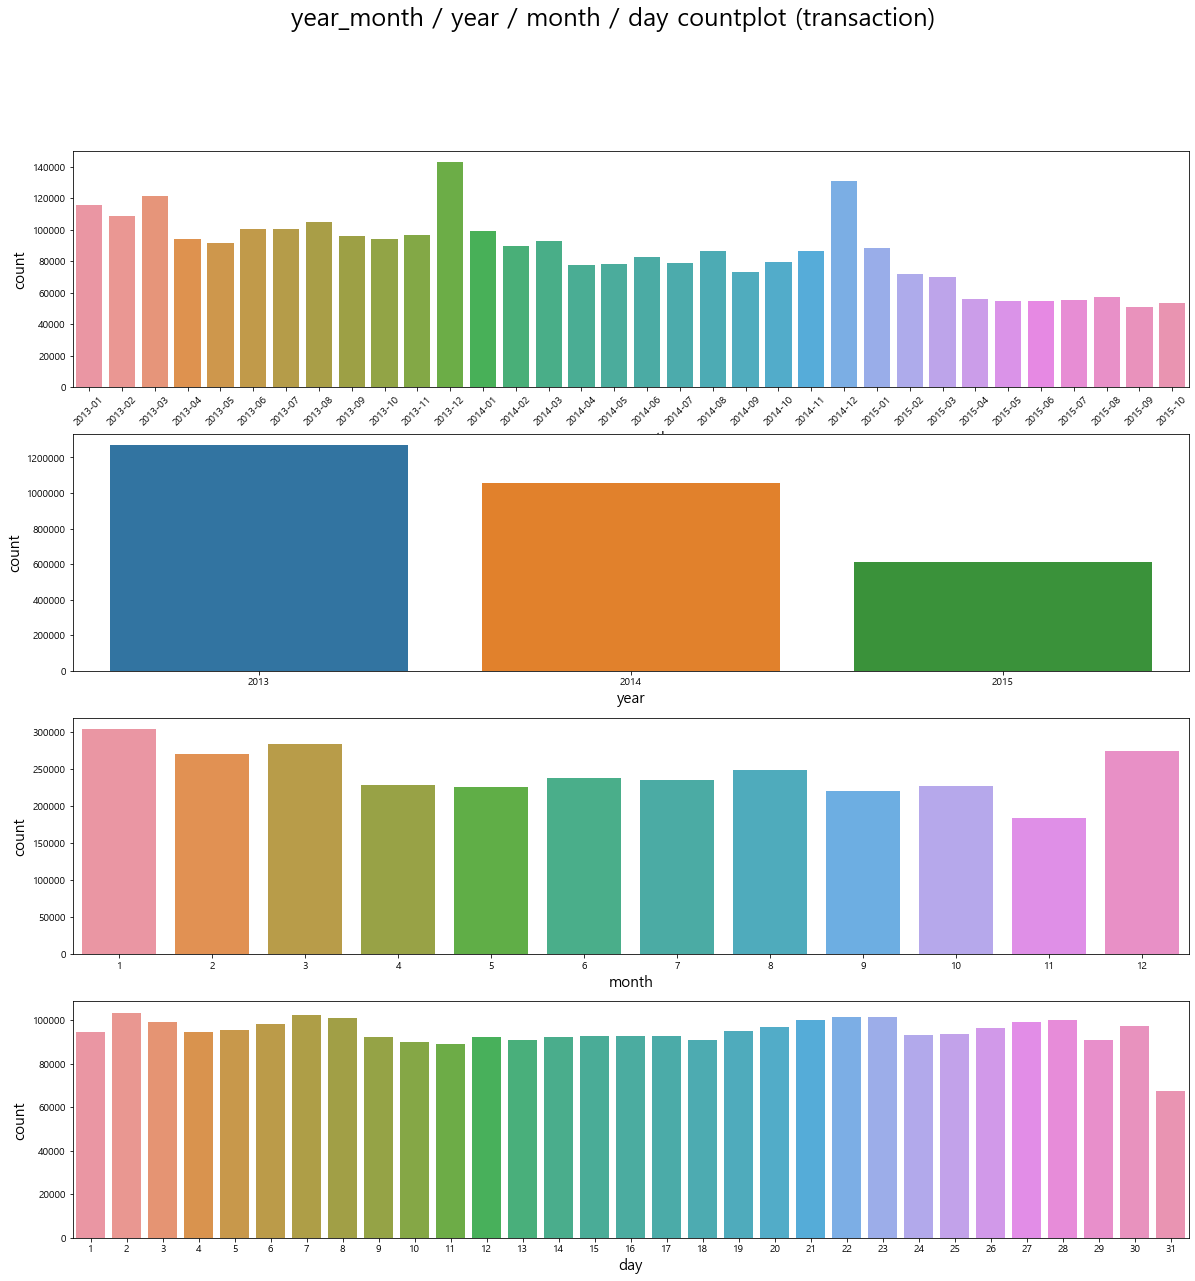

In [32]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
fig.suptitle('year_month / year / month / day countplot (transaction)', fontsize= 25)
g = sns.countplot(train.year_month, ax=ax[0], order=sorted(train.year_month.unique()))
g.set_xticklabels(g.get_xticklabels(), rotation=45)
sns.countplot(train.year, ax=ax[1])
sns.countplot(train.month, ax=ax[2])
sns.countplot(train.day, ax=ax[3])

# 2. [ date_block_num ]
* 첫 날을 기준으로 1달 간격으로 나눈거 (2013.01 => 0 / 2013.02 =>1 ..... / 2015.12 =>33)
* date_block_num 변화에 따른 거래량과, 거래액의 변화가 비슷한 양상을 보임

In [33]:
print('[ date_block_num ]'.format(train.date_block_num.nunique()))
print('- Unique : {}'.format(train.date_block_num.nunique()))
print('- Min: {}'.format(train.date_block_num.min()))
print('- Max: {}'.format(train.date_block_num.max()))

[ date_block_num ]
- Unique : 34
- Min: 0
- Max: 33


In [34]:
date_block_num_df=\
    train.groupby('date_block_num')['item_price','item_cnt_day']\
    .agg({'item_price':['sum','mean'],
          'item_cnt_day':['sum']}).reset_index()
date_block_num_df.columns=['date_block_num','item_price_sum','item_price_mean','item_cnt_sum']
date_block_num_df[:10]

,date_block_num,item_price_sum,item_price_mean,item_cnt_sum
0,0,8.221009e+07,710.625117,131476.0
1,1,7.557875e+07,695.866430,128088.0
2,2,8.429603e+07,694.680740,147140.0
3,3,6.151247e+07,653.637034,107189.0
4,4,5.727413e+07,624.179993,106970.0
5,5,6.334361e+07,630.893644,125381.0
6,6,6.219681e+07,618.578247,116966.0
7,7,6.543817e+07,624.576855,125291.0
8,8,7.270157e+07,756.228823,133332.0
9,9,7.391497e+07,784.643328,127541.0


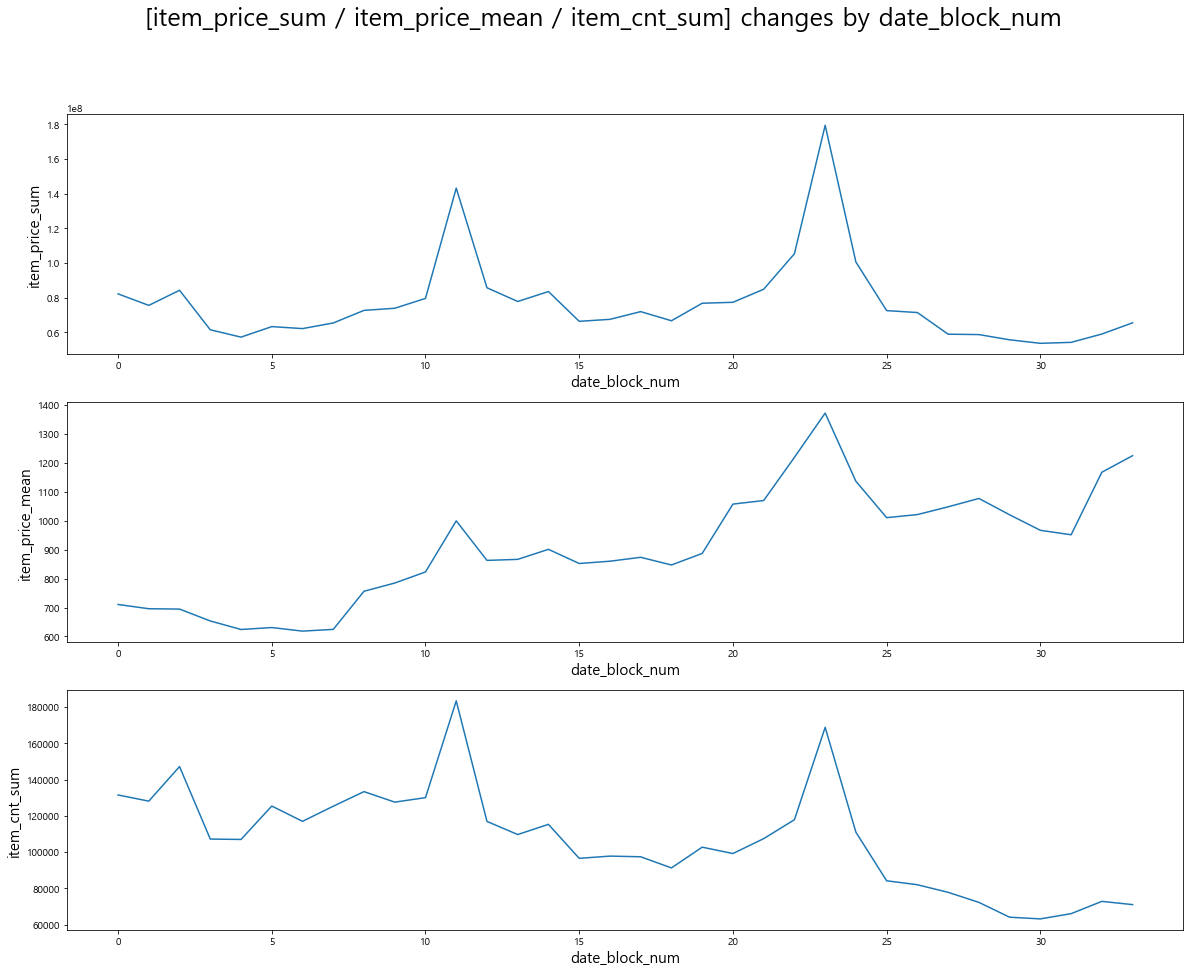

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle('[item_price_sum / item_price_mean / item_cnt_sum] changes by date_block_num ', fontsize= 25)

sns.lineplot(x='date_block_num',
             y='item_price_sum',
             data=date_block_num_df,
             ax=ax[0])

sns.lineplot(x='date_block_num',
             y='item_price_mean',
             data=date_block_num_df,
             ax=ax[1])

sns.lineplot(x='date_block_num',
             y='item_cnt_sum',
             data=date_block_num_df,
             ax=ax[2])

# 3. [ item ] ( id, name, price ,cnt_day)
* 최다 매출 item : sony playstation 4
* 최다 판매량 item : фирменный пакет майка 1с интерес белый	

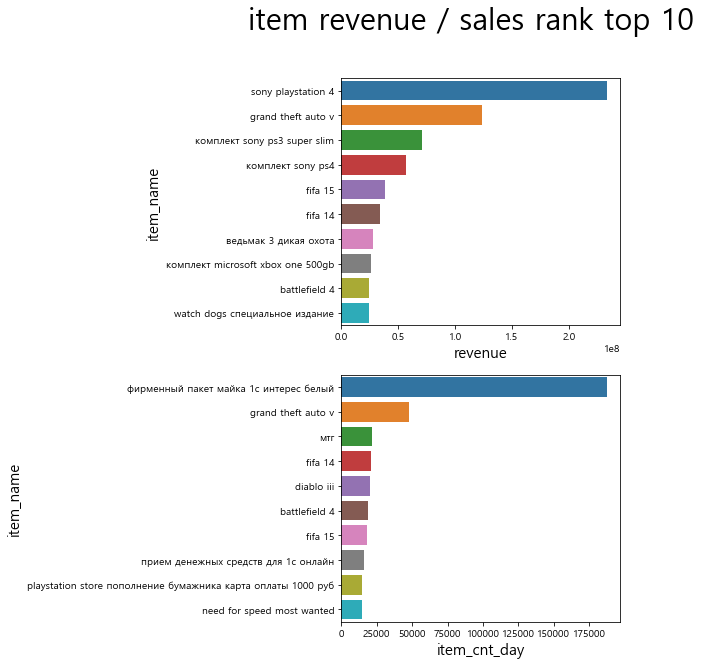

In [36]:
item_revenue_rank10=train.groupby('item_name')['item_name','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
item_cnt_rank10=train.groupby('item_name')['item_name','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]

fig, ax = plt.subplots(2,1, figsize=(5,10))
plt.suptitle('item revenue / sales rank top 10 ', fontsize=30)
sns.barplot(data=item_revenue_rank10,
            x='revenue', y='item_name', ax=ax[0])
sns.barplot(data=item_cnt_rank10,
            x='item_cnt_day', y='item_name', ax=ax[1])

# 4. [ item_category ] ( id, name, main, sub )
* 최다 판매량 category : Кино - DVD
* 최다 판매량 category_main : Кино
* 최다 판매량 category_sub : DVD
<br><br>
* 최다 판매액 category : Игры - PS3
* 최다 판매액 category_main : Игры
* 최다 판매액 category_sub : PS4	

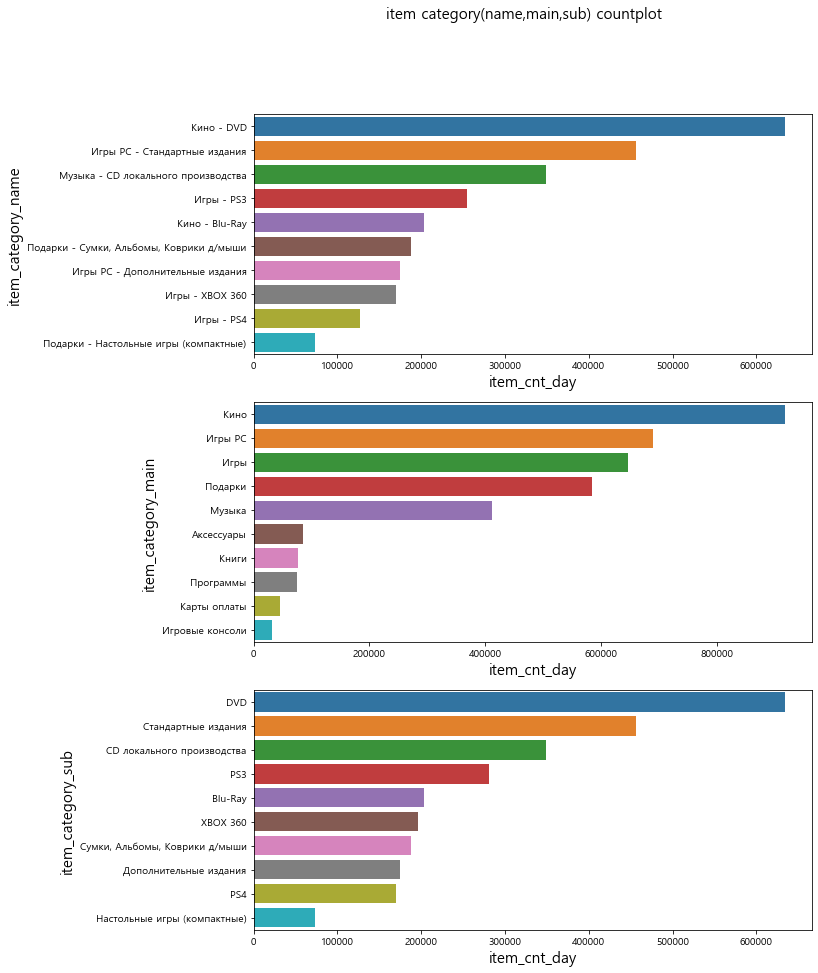

In [37]:
item_category_name10=train.groupby('item_category_name')['item_category_name','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
item_category_main10=train.groupby('item_category_main')['item_category_main','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
item_category_sub10=train.groupby('item_category_sub')['item_category_sub','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('item category(name,main,sub) countplot', fontsize=15)
sns.barplot(data=item_category_name10,
            x='item_cnt_day', y='item_category_name', ax=ax[0])
sns.barplot(data=item_category_main10,
            x='item_cnt_day', y='item_category_main', ax=ax[1])
sns.barplot(data=item_category_sub10,
            x='item_cnt_day', y='item_category_sub', ax=ax[2])

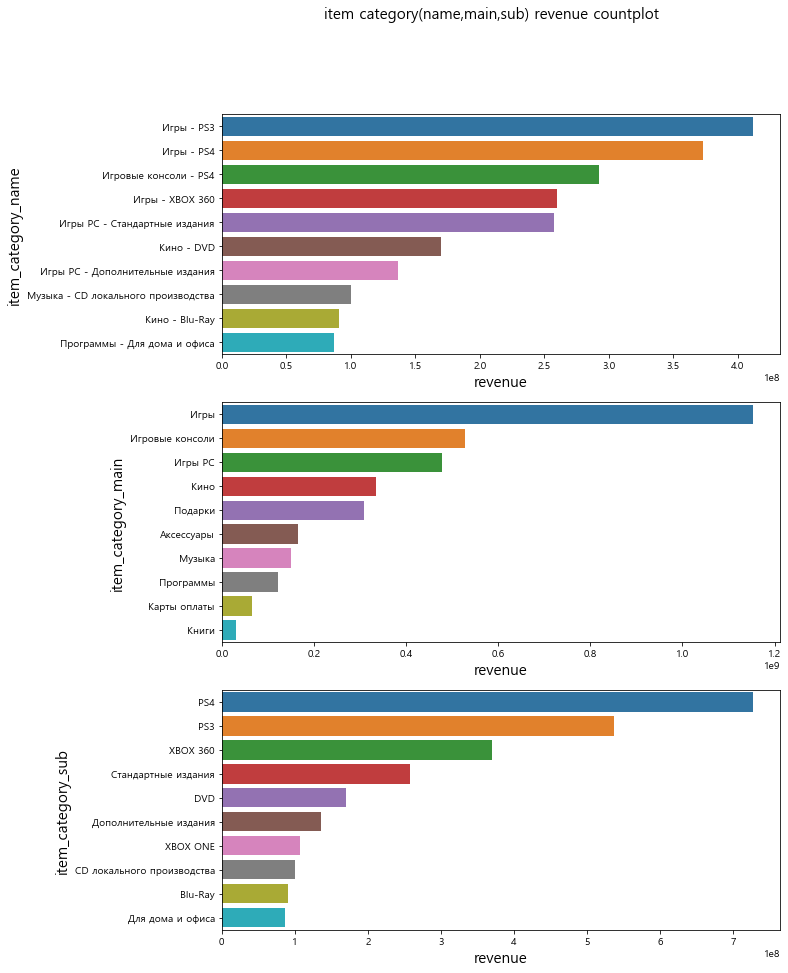

In [38]:
item_category_name10_rev=train.groupby('item_category_name')['item_category_name','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
item_category_main10_rev=train.groupby('item_category_main')['item_category_main','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
item_category_sub10_rev=train.groupby('item_category_sub')['item_category_sub','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('item category(name,main,sub) revenue countplot', fontsize=15)
sns.barplot(data=item_category_name10_rev,
            x='revenue', y='item_category_name', ax=ax[0])
sns.barplot(data=item_category_main10_rev,
            x='revenue', y='item_category_main', ax=ax[1])
sns.barplot(data=item_category_sub10_rev,
            x='revenue', y='item_category_sub', ax=ax[2])

# 5. [ shop ] ( id, name, city, type )
* 최다 판매량 shop : Москва ТЦ "Семеновский"
* 최다 판매량 city : москва
* 최다 판매량 type : тц
<br><br>
* 최다 판매액 shop : Москва ТЦ "Семеновский"
* 최다 판매액 city : москва
* 최다 판매액 type : тц

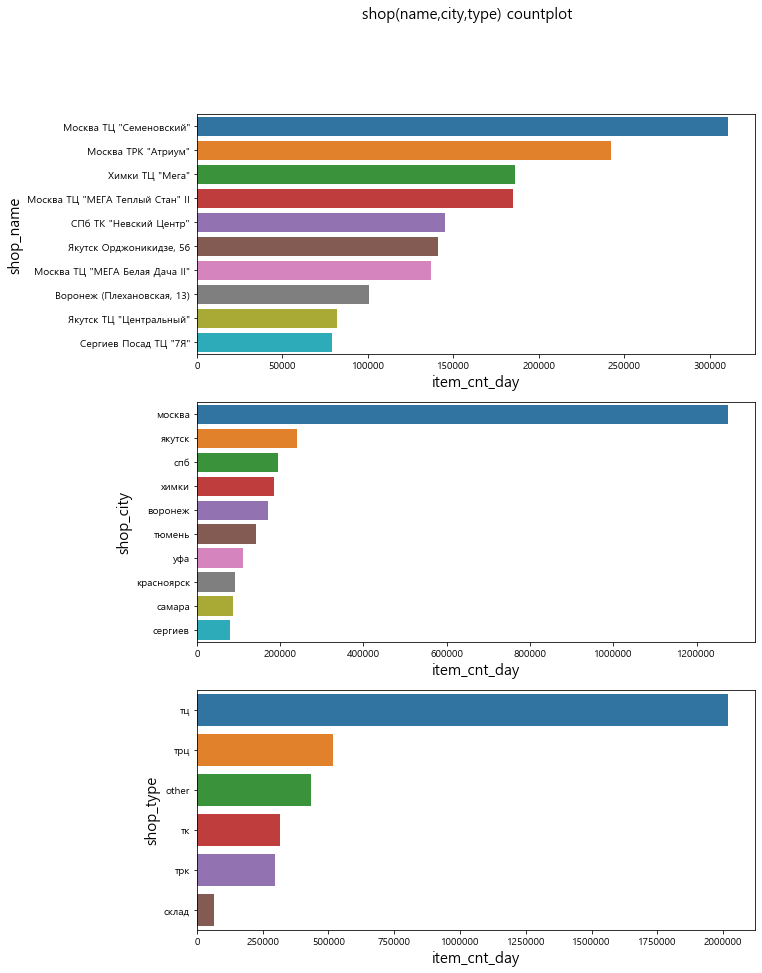

In [39]:
shop_name10=train.groupby('shop_name')['shop_name','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
shop_city10=train.groupby('shop_city')['shop_city','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]
shop_type10=train.groupby('shop_type')['shop_type','item_cnt_day'].sum().reset_index().sort_values(by='item_cnt_day',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('shop(name,city,type) countplot', fontsize=15)
sns.barplot(data=shop_name10,
            x='item_cnt_day', y='shop_name', ax=ax[0])
sns.barplot(data=shop_city10,
            x='item_cnt_day', y='shop_city', ax=ax[1])
sns.barplot(data=shop_type10,
            x='item_cnt_day', y='shop_type', ax=ax[2])

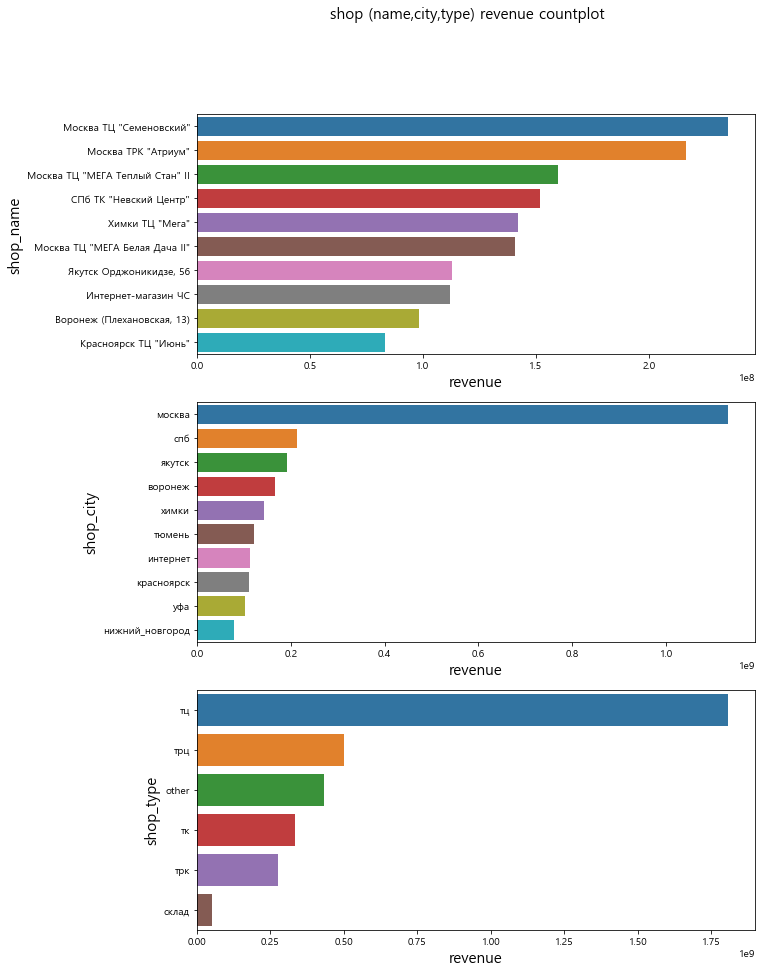

In [40]:
shop_name10_rev=train.groupby('shop_name')['shop_name','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
shop_city10_rev=train.groupby('shop_city')['shop_city','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]
shop_type10_rev=train.groupby('shop_type')['shop_type','revenue'].sum().reset_index().sort_values(by='revenue',ascending=False)[:10]


fig, ax = plt.subplots(3,1, figsize=(10,15))
plt.suptitle('shop (name,city,type) revenue countplot', fontsize=15)
sns.barplot(data=shop_name10_rev,
            x='revenue', y='shop_name', ax=ax[0])
sns.barplot(data=shop_city10_rev,
            x='revenue', y='shop_city', ax=ax[1])
sns.barplot(data=shop_type10_rev,
            x='revenue', y='shop_type', ax=ax[2])

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935825 entries, 0 to 2935824
Data columns (total 19 columns):
date                  datetime64[ns]
date_block_num        int64
item_id               int64
item_name             object
item_price            float64
item_cnt_day          float64
item_category_id      int64
item_category_name    object
item_category_main    object
item_category_sub     object
shop_id               int64
shop_name             object
shop_city             object
shop_type             object
revenue               float64
year_month            object
year                  int64
month                 int64
day                   int64
dtypes: datetime64[ns](1), float64(3), int64(7), object(8)
memory usage: 528.0+ MB


# 6. [ revenue & item_cnt_day variation] by date_block_num

In [42]:
date_block_num_group=train.groupby('date_block_num')['revenue','item_cnt_day']\
                                                    .agg({'revenue':['sum','mean','std'],
                                                          'item_cnt_day':['sum','mean','std']}).reset_index()

date_block_num_group.columns=['date_block_num',
                              'revenue_sum','revenue_mean','revenue_std',
                              'item_cnt_sum','item_cnt_mean','item_cnt_std']

date_block_num_group.head(3)

,date_block_num,revenue_sum,revenue_mean,revenue_std,item_cnt_sum,item_cnt_mean,item_cnt_std
0,0,9.194531e+07,794.776467,1454.291613,131476.0,1.136480,0.679523
1,1,9.066427e+07,834.761390,1579.883809,128088.0,1.179328,0.883324
2,2,1.049304e+08,864.727918,1740.433775,147140.0,1.212576,1.112839


In [43]:
date_block_num_group_unpivot = date_block_num_group.melt(id_vars=['date_block_num'], var_name='stat_type', value_name='value')
date_block_num_group_unpivot

,date_block_num,stat_type,value
0,0,revenue_sum,9.194531e+07
1,1,revenue_sum,9.066427e+07
2,2,revenue_sum,1.049304e+08
3,3,revenue_sum,6.915394e+07
4,4,revenue_sum,6.506531e+07
...,...,...,...
199,29,item_cnt_std,1.184695e+00
200,30,item_cnt_std,1.017717e+00
201,31,item_cnt_std,1.137415e+00
202,32,item_cnt_std,6.132888e+00


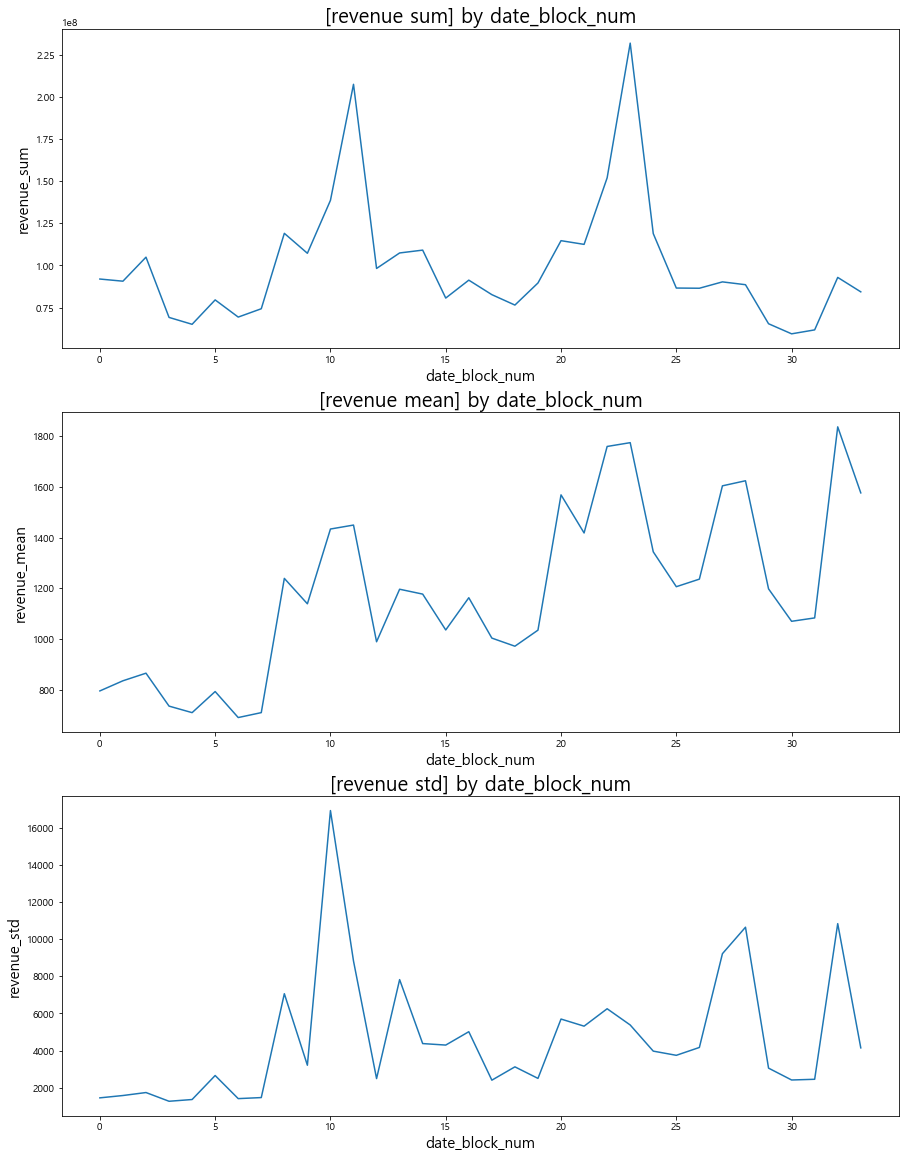

In [44]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(15,20))
#plt.suptitle('revenue lineplot by date_block_num', fontsize=25)

ax0.set_title('[revenue sum] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='revenue_sum',ax=ax0)

ax1.set_title('[revenue mean] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='revenue_mean',ax=ax1)

ax2.set_title('[revenue std] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='revenue_std',ax=ax2)

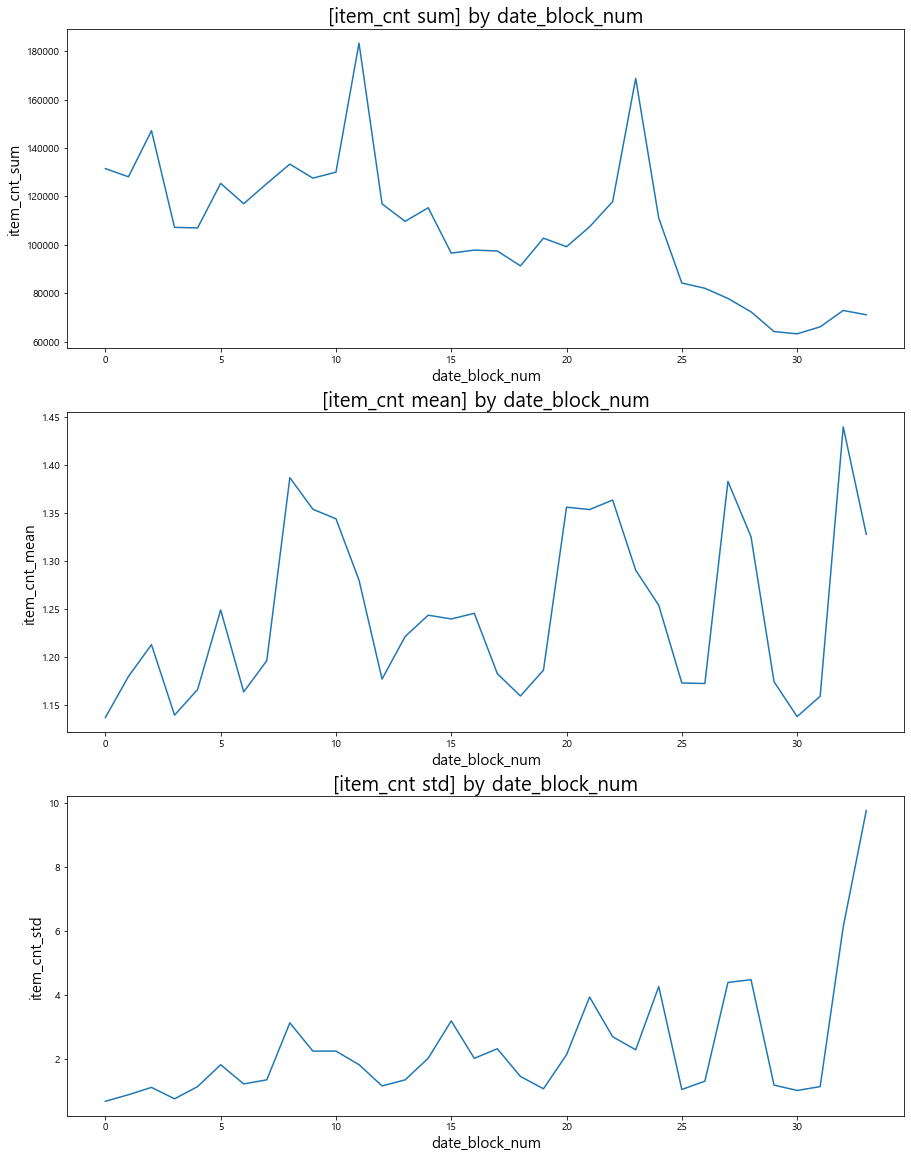

In [45]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(15,20))
#plt.suptitle('item_cnt lineplot by date_block_num', fontsize=25)

ax0.set_title('[item_cnt sum] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='item_cnt_sum',ax=ax0)

ax1.set_title('[item_cnt mean] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='item_cnt_mean',ax=ax1)

ax2.set_title('[item_cnt std] by date_block_num')
sns.lineplot(data=date_block_num_group,
            x='date_block_num', y='item_cnt_std',ax=ax2)

# item_price 와 item_cnt_day 간 상관관계 확인

In [46]:
print('# item_price / item_cnt_day corr : {}'.format(train['item_price'].corr(train['item_cnt_day'])))
print('# 값    0.01 /  상관관계 없다고 판단됨')

# item_price / item_cnt_day corr : 0.01119649301037416
# 값    0.01 /  상관관계 없다고 판단됨


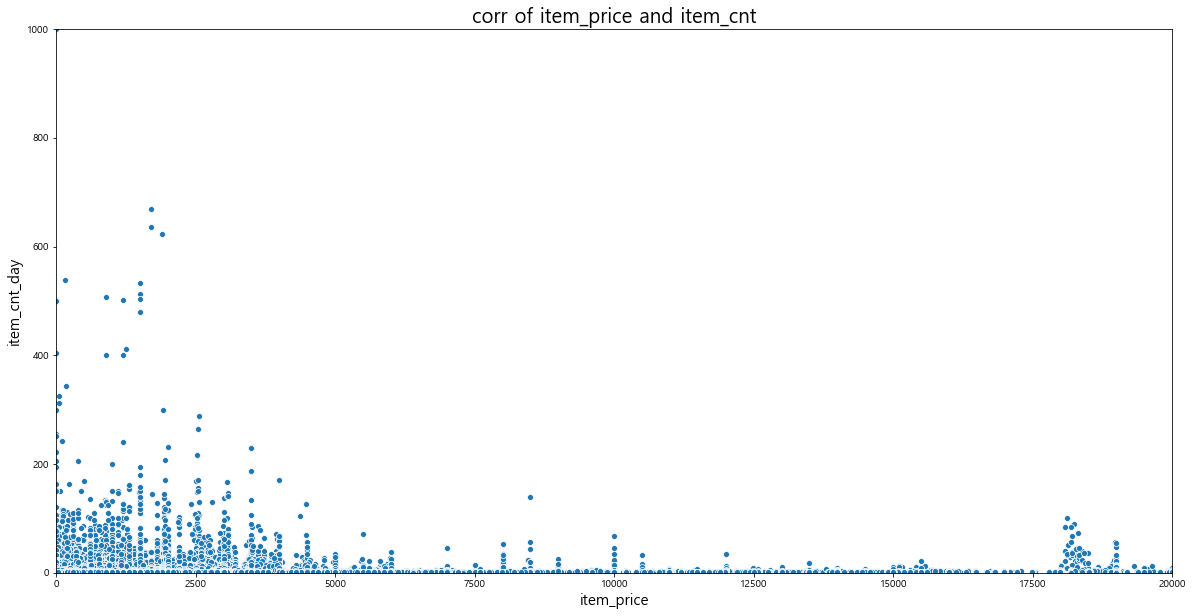

In [47]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('corr of item_price and item_cnt')
ax=sns.scatterplot(data=train, x='item_price', y='item_cnt_day')
ax.set_xlim(0, 20000)
ax.set_ylim(0, 1000)
plt.show()

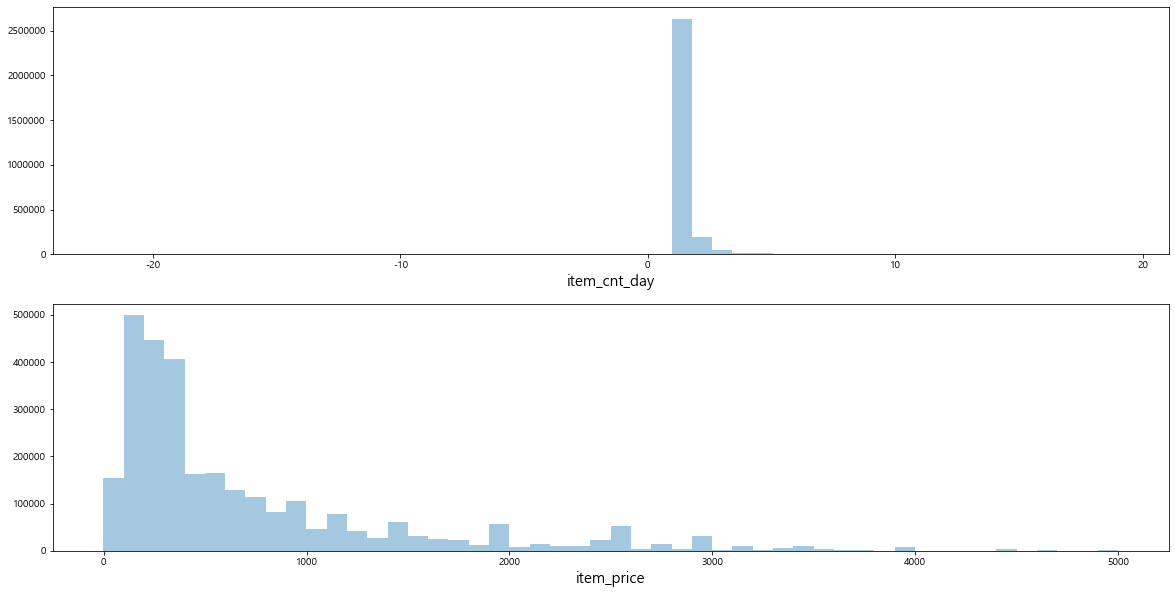

In [48]:
fig, ax = plt.subplots(2,1,figsize = (20,10))
sns.distplot(train['item_cnt_day'].loc[train['item_cnt_day'] < 20], 
             ax=ax[0],kde=False)
sns.distplot(train['item_price'].loc[train['item_price'] < 5000], 
             ax=ax[1], kde=False)

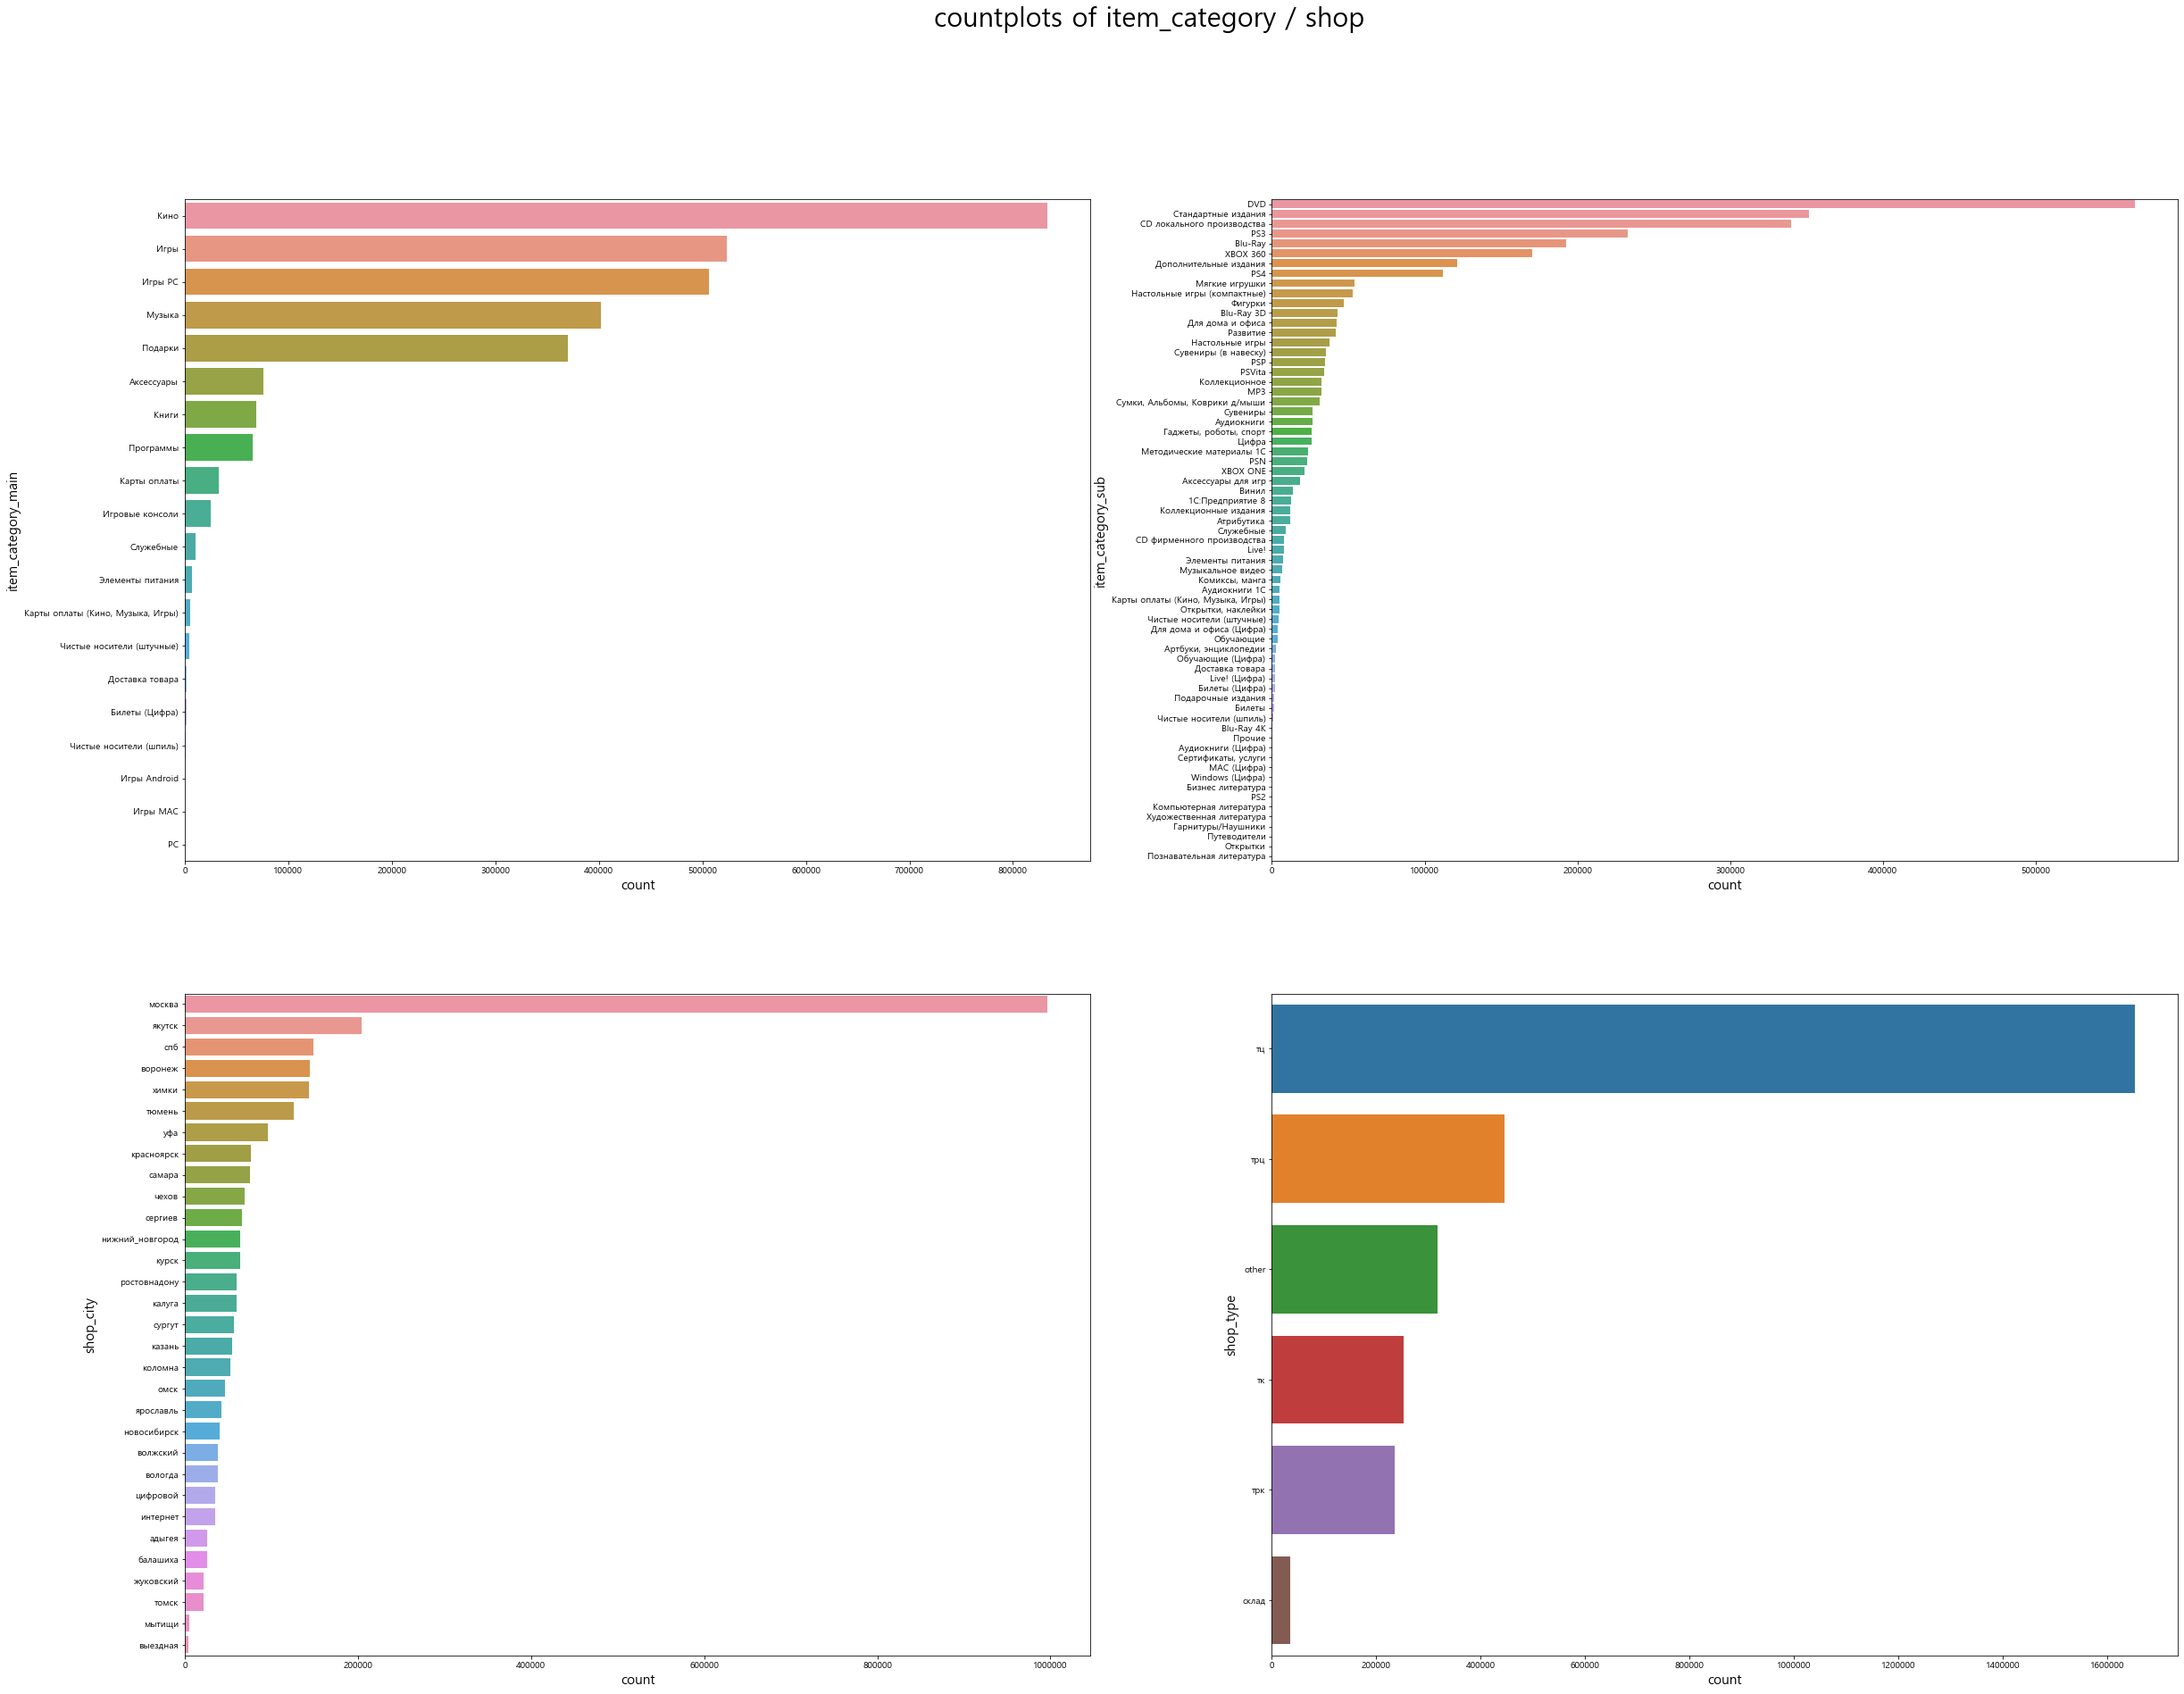

In [49]:
fig, ax = plt.subplots(2,2, figsize=(40,30))
plt.suptitle('countplots of item_category / shop',fontsize=30)
#plt.xticks(rotation=90) 

sns.countplot(y=train['item_category_main'], ax=ax[0][0],
              order=train['item_category_main'].value_counts().index)

sns.countplot(y=train['item_category_sub'], ax=ax[0][1],
              order=train['item_category_sub'].value_counts().index)

sns.countplot(y=train['shop_city'], ax=ax[1][0],
              order=train['shop_city'].value_counts().index)

sns.countplot(y=train['shop_type'], ax=ax[1][1],
              order=train['shop_type'].value_counts().index)

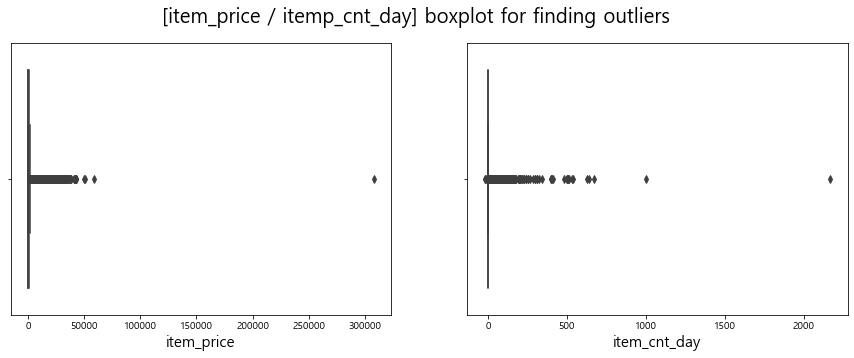

In [50]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.suptitle('[item_price / itemp_cnt_day] boxplot for finding outliers',fontsize=20)
#plt.xticks(rotation=90)
sns.boxplot(train['item_price'],  ax=ax[0]) #orient='v'
sns.boxplot(train['item_cnt_day'], ax=ax[1])

In [51]:
train.loc[train.item_cnt_day>2000]

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
2909794,2015-10-28,33,11373,доставка до пункта выдачи,0.908714,2169.0,9,Доставка товара,Доставка товара,Доставка товара,12,Интернет-магазин ЧС,интернет,other,1971.0,2015-10,2015,10,28


In [52]:
train.loc[train.item_price>300000]

,date,date_block_num,item_id,item_name,item_price,item_cnt_day,item_category_id,item_category_name,item_category_main,item_category_sub,shop_id,shop_name,shop_city,shop_type,revenue,year_month,year,month,day
1163150,2013-12-13,11,6066,radmin 3 522 лиц,307980.0,1.0,75,Программы - Для дома и офиса,Программы,Для дома и офиса,12,Интернет-магазин ЧС,интернет,other,307980.0,2013-12,2013,12,13


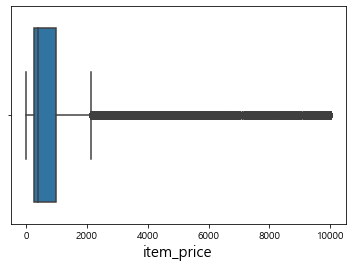

In [53]:
sns.boxplot(train['item_price'][train['item_price']<10000]) #orient='v'

In [54]:
len(train['item_price'][train['item_price']>2000])

266190

In [55]:
len(train['item_price'])

2935825

In [56]:
len(train['item_price'][train['item_price']>2000]) / len(train['item_price'])* 100

9.06695732885986

In [66]:
np.array(train['item_price'].nlargest(20))

array([307980.,  59200.,  50999.,  49782.,  42990.,  42990.,  42990.,
        42990.,  42000.,  41990.,  41990.,  41990.,  40991.,  40900.,
        37991.,  37991.,  36990.,  36990.,  36990.,  36990.])

In [67]:
np.array(train['item_cnt_day'].nlargest(20))

array([2169., 1000.,  669.,  637.,  624.,  539.,  533.,  512.,  508.,
        504.,  502.,  501.,  500.,  500.,  480.,  412.,  405.,  401.,
        401.,  343.])